# Importing Necessary Libraries

In [2]:
# Import the libraries you will be using for analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
#importing os to change working directory
import os
print(os.getcwd())

#changing current working directory
os.chdir('C:\\Users\\lenovo\\Assignment\\Datasets and Dictionary\\trip_records')
print(f'Current working directory changed to {os.getcwd()}')

C:\Users\lenovo\Assignment\github
Current working directory changed to C:\Users\lenovo\Assignment\Datasets and Dictionary\trip_records


# Loading the Sampled Data

In [6]:
# Load the new data file
df = pd.read_parquet('sampled_data.parquet')

In [7]:
#view of top 5 rows
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,Airport_fee
0,2,2023-01-01 00:07:18,2023-01-01 00:23:15,1.0,7.74,1.0,N,138,256,2,32.40,6.0,0.5,0.00,0.0,1.0,41.15,0.0,1.25,NaN
1,2,2023-01-01 00:16:41,2023-01-01 00:21:46,2.0,1.24,1.0,N,161,237,1,7.90,1.0,0.5,2.58,0.0,1.0,15.48,2.5,0.00,NaN
2,2,2023-01-01 00:14:03,2023-01-01 00:24:36,3.0,1.44,1.0,N,237,141,2,11.40,1.0,0.5,0.00,0.0,1.0,16.40,2.5,0.00,NaN
3,2,2023-01-01 00:24:30,2023-01-01 00:29:55,1.0,0.54,1.0,N,143,142,2,6.50,1.0,0.5,0.00,0.0,1.0,11.50,2.5,0.00,NaN
4,2,2023-01-01 00:43:00,2023-01-01 01:01:00,NaN,19.24,NaN,None,66,107,0,25.64,0.0,0.5,5.93,0.0,1.0,35.57,NaN,NaN,NaN


In [8]:
#overview of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1896400 entries, 0 to 1896399
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

In [9]:
#checking the shape of the data
df.shape

(1896400, 20)

# Fixing Columns

In [11]:
#fixing index 
df.reset_index(drop= True, inplace= True)

print(df['store_and_fwd_flag'].value_counts()  / df.shape[0] * 100)

#Since majority of record was not held in vehicle memory before sending to the vendorwe  can drop this column
df.drop(['store_and_fwd_flag'], axis= 1, inplace= True)

store_and_fwd_flag
N    95.986448
Y     0.592649
Name: count, dtype: float64


In [12]:
# Combine the two airport fee columns
df['airport_fee'] = df['airport_fee'].mask(df['airport_fee'].isna(), df['Airport_fee'])

#dropping the 'Airport_fee' column
df.drop(['Airport_fee'], axis= 1, inplace= True)

In [13]:
# check where values of fare amount are negative
df[df['fare_amount'] < 0]['fare_amount'].count()

0

In [14]:
# Analyse RatecodeID for the negative fare amounts

#there are no negative 'fare_amount'

#however we can see an unusual RatecodeID i.e 99.0 which is present 0.5% 
print(df['RatecodeID'].value_counts(normalize= True) * 100)

# Since 'Standard rate' is applied the most we will impute the values with median
RatecodeID_median = df['RatecodeID'].median() 

df['RatecodeID'] = df['RatecodeID'].apply(lambda x :  RatecodeID_median if x > 6 else x )



RatecodeID
1.0     94.416295
2.0      3.913130
99.0     0.571764
5.0      0.561008
3.0      0.334366
4.0      0.203273
6.0      0.000164
Name: proportion, dtype: float64


In [15]:
#checking the distribution again
print(df['RatecodeID'].value_counts(normalize= True) * 100)

RatecodeID
1.0    94.988059
2.0     3.913130
5.0     0.561008
3.0     0.334366
4.0     0.203273
6.0     0.000164
Name: proportion, dtype: float64


In [16]:
# Find which columns have negative values
negative_value_colums = [] 
for col in df.columns:
    if df[col].dtype.kind in 'biufc':
        if df[col].lt(0).any():
           negative_value_colums.append(col)
print(negative_value_colums)

['extra', 'mta_tax', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'airport_fee']


In [17]:
# fix these negative values

#looping through instance 'negative_value_colums'
for column in negative_value_colums:
    
    try :
        #applying a lambda function to values less than 0
        df[column] = df[column].apply(lambda x : 0 if x < 0 else x)
        
    except Exception as e:
        print(f"Error assiging '0' to {column}: {e}")
    

# Handling Missing Values:

In [19]:
# Find the proportion of missing values in each column
df.isna().sum().sort_values(ascending = False) / df.shape[0] * 100

airport_fee              3.420903
congestion_surcharge     3.420903
passenger_count          3.420903
RatecodeID               3.420903
extra                    0.000000
total_amount             0.000000
improvement_surcharge    0.000000
tolls_amount             0.000000
tip_amount               0.000000
mta_tax                  0.000000
VendorID                 0.000000
tpep_pickup_datetime     0.000000
payment_type             0.000000
DOLocationID             0.000000
PULocationID             0.000000
trip_distance            0.000000
tpep_dropoff_datetime    0.000000
fare_amount              0.000000
dtype: float64

In [20]:
#to handle the the missing values, we will use the probability distribution so that each passenger count has an equal chance
df['passenger_count'].value_counts(normalize= True)

passenger_count
1.0    0.751954
2.0    0.151403
3.0    0.037692
4.0    0.021041
0.0    0.016206
5.0    0.013033
6.0    0.008659
8.0    0.000006
7.0    0.000003
9.0    0.000003
Name: proportion, dtype: float64

In [21]:
# Display the rows with null values
df[df['passenger_count'].isna()]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
4,2,2023-01-01 00:43:00,2023-01-01 01:01:00,NaN,19.24,NaN,66,107,0,25.64,0.0,0.5,5.93,0.00,1.0,35.57,NaN,NaN
15,2,2023-01-01 00:41:50,2023-01-01 01:14:50,NaN,10.77,NaN,151,106,0,45.38,0.0,0.5,11.19,6.55,1.0,67.12,NaN,NaN
42,2,2023-01-01 00:37:21,2023-01-01 00:54:18,NaN,4.52,NaN,114,262,0,25.38,0.0,0.5,0.00,0.00,1.0,29.38,NaN,NaN
43,2,2023-01-01 00:44:03,2023-01-01 01:13:49,NaN,9.19,NaN,239,256,0,40.00,0.0,0.5,2.20,0.00,1.0,46.20,NaN,NaN
46,2,2023-01-01 00:50:55,2023-01-01 01:19:06,NaN,2.74,NaN,90,48,0,18.48,0.0,0.5,3.37,0.00,1.0,25.85,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1896343,1,2023-09-30 23:18:31,2023-09-30 23:30:35,NaN,0.00,NaN,43,229,0,12.55,0.0,0.5,0.00,0.00,1.0,16.55,NaN,NaN
1896356,1,2023-09-30 23:42:07,2023-10-01 00:05:22,NaN,0.00,NaN,255,209,0,34.02,0.0,0.5,0.00,0.00,1.0,38.02,NaN,NaN
1896369,1,2023-09-30 23:59:39,2023-10-01 00:15:03,NaN,0.00,NaN,137,249,0,21.50,0.0,0.5,0.00,0.00,1.0,25.50,NaN,NaN
1896376,1,2023-09-30 23:47:09,2023-10-01 00:03:01,NaN,3.50,NaN,233,144,0,21.28,0.0,0.5,0.00,0.00,1.0,25.28,NaN,NaN


In [22]:
# Impute NaN values in 'passenger_count'

#subsetting 'passenger_count' where passenger_count > 0 to get distribution of passenger count
value_counts = df[df['passenger_count'] > 0 ]['passenger_count'].value_counts(normalize= True)

# extracting the the values i.e is  the passenger count
values = value_counts.index.to_list()

#extracting the probabilities of each passenger count
probabilities = value_counts.values

# Using numpy's random.choice() we will geratate an array of values that with the size the size of missing values with probabilites
missing_replacements = np.random.choice( values, size=df['passenger_count'].isna().sum() ,  p=probabilities)

#assiging these values to the rows where passanger count is NaN:
df.loc[df['passenger_count'].isna(), 'passenger_count'] = missing_replacements

In [23]:
#we can check the distribution remains the same
df['passenger_count'].value_counts(normalize=True) * 100

passenger_count
1.0    75.235393
2.0    15.145961
3.0     3.772253
4.0     2.105147
0.0     1.565123
5.0     1.308901
6.0     0.866062
8.0     0.000633
7.0     0.000264
9.0     0.000264
Name: proportion, dtype: float64

In [24]:
# passengers where passengr count is zero
df[df['passenger_count'] <= 0]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
118,2,2023-01-01 00:47:28,2023-01-01 00:47:32,0.0,0.0,5.0,232,232,1,14.0,0.0,0.0,0.0,0.0,1.0,15.0,0.0,0.0
192,1,2023-01-01 00:50:09,2023-01-01 01:14:29,0.0,3.0,1.0,237,90,1,22.6,3.5,0.5,6.9,0.0,1.0,34.5,2.5,0.0
197,1,2023-01-01 00:23:01,2023-01-01 00:32:42,0.0,2.4,1.0,43,166,1,12.8,3.5,0.5,2.2,0.0,1.0,20.0,2.5,0.0
234,1,2023-01-01 00:42:48,2023-01-01 00:52:02,0.0,1.0,1.0,162,161,1,10.0,3.5,0.5,1.5,0.0,1.0,16.5,2.5,0.0
235,1,2023-01-01 00:58:49,2023-01-01 01:04:32,0.0,0.7,1.0,186,234,1,6.5,3.5,0.5,2.3,0.0,1.0,13.8,2.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1895962,1,2023-09-30 22:09:45,2023-09-30 22:14:52,0.0,0.7,1.0,142,230,1,6.5,3.5,0.5,2.3,0.0,1.0,13.8,2.5,0.0
1895986,1,2023-09-30 22:42:00,2023-09-30 22:56:02,0.0,2.5,1.0,144,33,1,15.6,3.5,0.5,4.1,0.0,1.0,24.7,2.5,0.0
1896083,1,2023-09-30 23:04:02,2023-09-30 23:05:11,0.0,0.2,1.0,50,50,1,3.7,3.5,0.5,1.0,0.0,1.0,9.7,2.5,0.0
1896224,1,2023-09-30 23:26:07,2023-09-30 23:38:31,0.0,1.3,1.0,161,100,1,12.1,3.5,0.5,3.4,0.0,1.0,20.5,2.5,0.0


In [25]:
#count of passengers with count 0 
df.loc[df['passenger_count'] <= 0, 'passenger_count' ].count()

29681

In [26]:
#checking the distribution
df['passenger_count'].value_counts(normalize=True) * 100

passenger_count
1.0    75.235393
2.0    15.145961
3.0     3.772253
4.0     2.105147
0.0     1.565123
5.0     1.308901
6.0     0.866062
8.0     0.000633
7.0     0.000264
9.0     0.000264
Name: proportion, dtype: float64

In [27]:
#creating a pandas series to extract a values i.e the passenger count and probabilites of the passenger
value_counts = df.loc[df['passenger_count'] > 0, 'passenger_count' ].value_counts(normalize = True)

#creating a list of values i.e. the passenger count
values = value_counts.index.to_list()

#creating probabilites
probabilities = value_counts.values


#using np.random.choice() to create a weighted random choice:
zero_replacements = np.random.choice(values, size = df.loc[df['passenger_count'] <= 0, 'passenger_count' ].count() , p = probabilities)

#assigning the replacements
df.loc[df['passenger_count'] <= 0, 'passenger_count' ] = zero_replacements

In [28]:
#verifying the distribution remains the same:
df['passenger_count'].value_counts(normalize=True) * 100

passenger_count
1.0    76.430342
2.0    15.390688
3.0     3.830099
4.0     2.140002
5.0     1.327568
6.0     0.880141
8.0     0.000633
7.0     0.000264
9.0     0.000264
Name: proportion, dtype: float64

In [29]:
# Display the rows with null values
df[df['RatecodeID'].isna()]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
4,2,2023-01-01 00:43:00,2023-01-01 01:01:00,4.0,19.24,NaN,66,107,0,25.64,0.0,0.5,5.93,0.00,1.0,35.57,NaN,NaN
15,2,2023-01-01 00:41:50,2023-01-01 01:14:50,5.0,10.77,NaN,151,106,0,45.38,0.0,0.5,11.19,6.55,1.0,67.12,NaN,NaN
42,2,2023-01-01 00:37:21,2023-01-01 00:54:18,1.0,4.52,NaN,114,262,0,25.38,0.0,0.5,0.00,0.00,1.0,29.38,NaN,NaN
43,2,2023-01-01 00:44:03,2023-01-01 01:13:49,1.0,9.19,NaN,239,256,0,40.00,0.0,0.5,2.20,0.00,1.0,46.20,NaN,NaN
46,2,2023-01-01 00:50:55,2023-01-01 01:19:06,1.0,2.74,NaN,90,48,0,18.48,0.0,0.5,3.37,0.00,1.0,25.85,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1896343,1,2023-09-30 23:18:31,2023-09-30 23:30:35,1.0,0.00,NaN,43,229,0,12.55,0.0,0.5,0.00,0.00,1.0,16.55,NaN,NaN
1896356,1,2023-09-30 23:42:07,2023-10-01 00:05:22,1.0,0.00,NaN,255,209,0,34.02,0.0,0.5,0.00,0.00,1.0,38.02,NaN,NaN
1896369,1,2023-09-30 23:59:39,2023-10-01 00:15:03,1.0,0.00,NaN,137,249,0,21.50,0.0,0.5,0.00,0.00,1.0,25.50,NaN,NaN
1896376,1,2023-09-30 23:47:09,2023-10-01 00:03:01,1.0,3.50,NaN,233,144,0,21.28,0.0,0.5,0.00,0.00,1.0,25.28,NaN,NaN


In [30]:
#distribution of RatecodeID
df['RatecodeID'].value_counts(normalize= True) * 100

RatecodeID
1.0    94.988059
2.0     3.913130
5.0     0.561008
3.0     0.334366
4.0     0.203273
6.0     0.000164
Name: proportion, dtype: float64

In [31]:
# Fix missing values in 'RatecodeID'

# Impute NaN values in 'RatecodeID'
print(df['RatecodeID'].value_counts(normalize= True) * 100)

# Since 'Standard rate' is applied the most we will impute the  NaN values with mode
RatecodeID_mode = df['RatecodeID'].mode()[0]
df['RatecodeID'].fillna(RatecodeID_mode,inplace= True)

RatecodeID
1.0    94.988059
2.0     3.913130
5.0     0.561008
3.0     0.334366
4.0     0.203273
6.0     0.000164
Name: proportion, dtype: float64


In [32]:
#verifying
df['RatecodeID'].isna().sum()

0

In [33]:
# handle null values in congestion_surcharge
df['congestion_surcharge'].isnull().sum() 

#there are no null values

64874

In [34]:
# Handle any remaining missing values
df.isna().sum()

VendorID                     0
tpep_pickup_datetime         0
tpep_dropoff_datetime        0
passenger_count              0
trip_distance                0
RatecodeID                   0
PULocationID                 0
DOLocationID                 0
payment_type                 0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
improvement_surcharge        0
total_amount                 0
congestion_surcharge     64874
airport_fee              64874
dtype: int64

In [35]:
df.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1896400 entries, 0 to 1896399
Data columns (total 18 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   VendorID               1896400 non-null  int64         
 1   tpep_pickup_datetime   1896400 non-null  datetime64[us]
 2   tpep_dropoff_datetime  1896400 non-null  datetime64[us]
 3   passenger_count        1896400 non-null  float64       
 4   trip_distance          1896400 non-null  float64       
 5   RatecodeID             1896400 non-null  float64       
 6   PULocationID           1896400 non-null  int64         
 7   DOLocationID           1896400 non-null  int64         
 8   payment_type           1896400 non-null  int64         
 9   fare_amount            1896400 non-null  float64       
 10  extra                  1896400 non-null  float64       
 11  mta_tax                1896400 non-null  float64       
 12  tip_amount             18964

# Handling Outliers

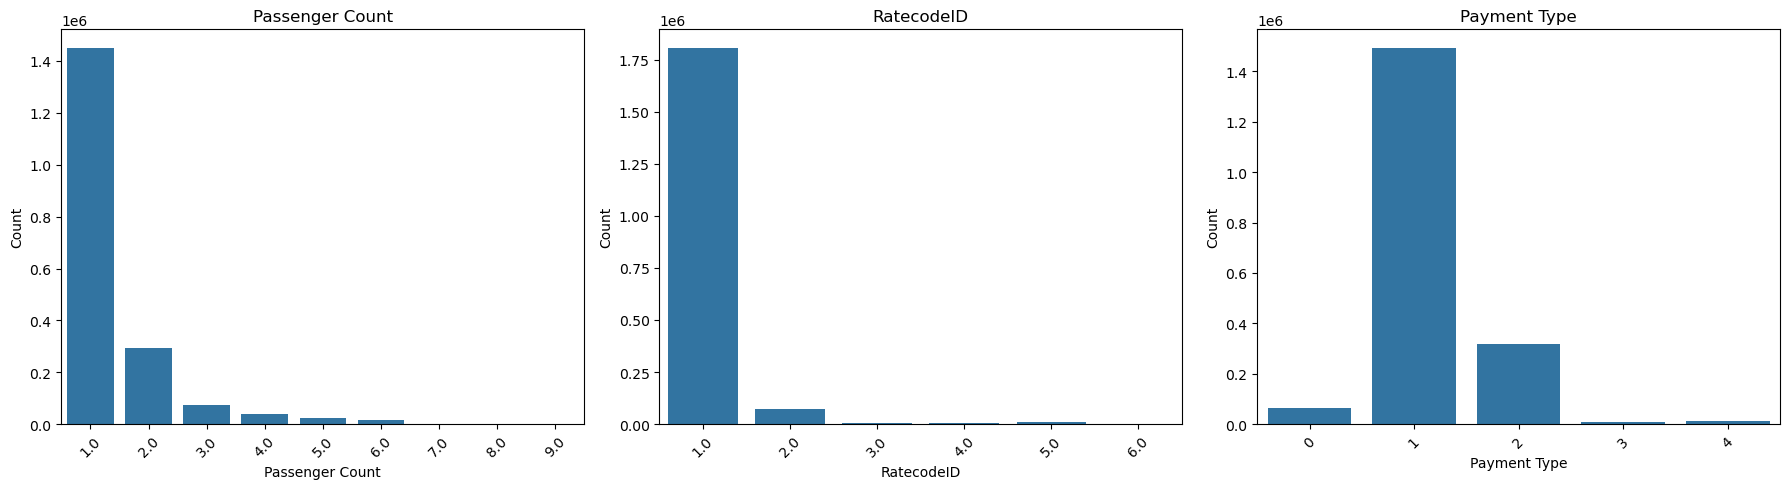

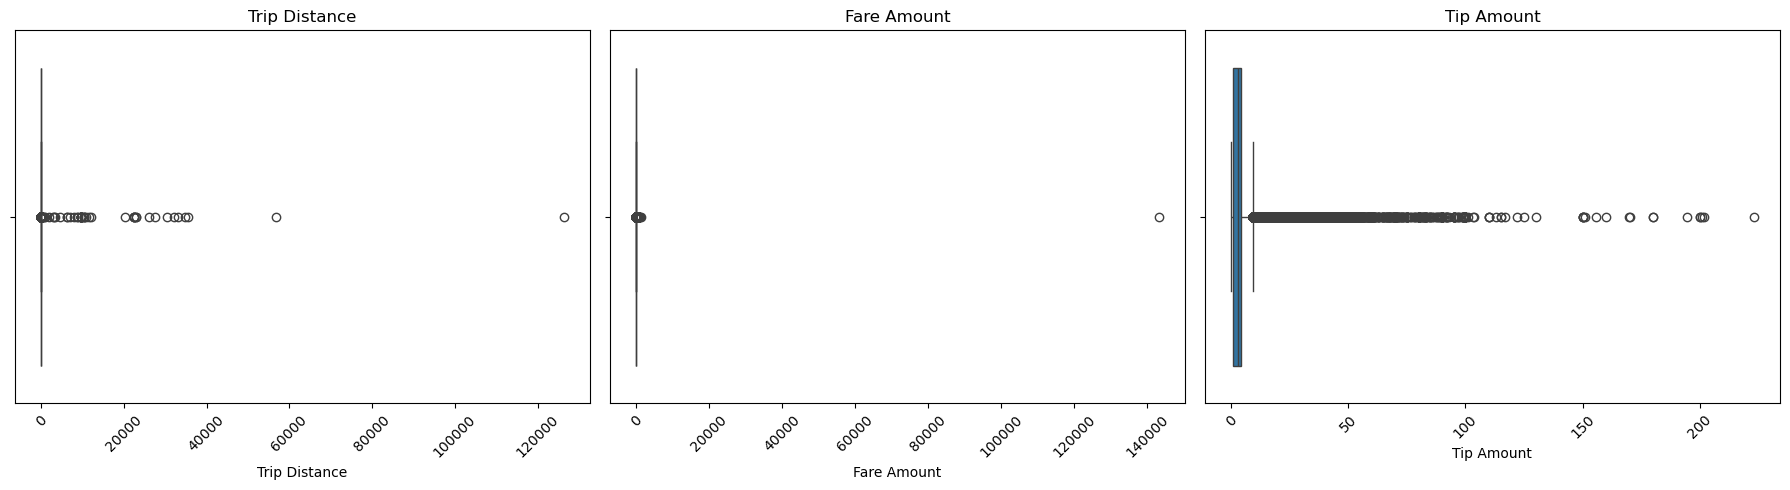

In [37]:
# Describe the data and check if there are any potential outliers present
# Check for potential out of place values in various columns
# sampled_taxi_records.select_dtypes(include= ['int64', 'float64']).describe()


fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # Ensure symmetrical layout

# Passenger Count
axes[0].set_title('Passenger Count')
sns.countplot(x='passenger_count', data=df, ax=axes[0])
axes[0].set_xlabel('Passenger Count')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# RatecodeID
axes[1].set_title('RatecodeID')
sns.countplot(x='RatecodeID', data=df, ax=axes[1])
axes[1].set_xlabel('RatecodeID')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

# Payment Type
axes[2].set_title('Payment Type')
sns.countplot(x='payment_type', data=df, ax=axes[2])
axes[2].set_xlabel('Payment Type')
axes[2].set_ylabel('Count')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()  # Adjust spacing
plt.show()

#Analysis subplot 1 : there are less trips with >6 passengers
#Analysis subplot 2 : RatecodeID 1 is the most common value, and there are some records with RatecodeID 99, which is not a standard value.
#Analysis subplot 3 :  Payment type 1 is the most common value, and there are some records with payment type 0, which is not a standard value.


# --- Second set of plots (Boxplots) ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # Ensure symmetrical layout

# Trip Distance
axes[0].set_title('Trip Distance')
sns.boxplot(x='trip_distance', data=df, ax=axes[0])
axes[0].set_xlabel('Trip Distance')
axes[0].tick_params(axis='x', rotation=45)

# Fare Amount
axes[1].set_title('Fare Amount')
sns.boxplot(x='fare_amount', data=df, ax=axes[1])
axes[1].set_xlabel('Fare Amount')
axes[1].tick_params(axis='x', rotation=45)

# Tip Amount
axes[2].set_title('Tip Amount')
sns.boxplot(x='tip_amount', data=df, ax=axes[2])
axes[2].set_xlabel('Tip Amount')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()  # Adjust spacing
plt.show()

#Analysis subplot 1 : there are some outliers in fare_amount.
#Analysis subplot 2 : tip_amount looks, however, there seems to be 1/2 outliers, which need to validated, if those records are good or bad
#Analysis subplot 3 :  there are some outliers in trip_distance

In [38]:
''' 
Aanalysis:
1. The 'passenger_count' has passenger upto 9 passenger which is not ideal
2. The 'trip_distance' column has outliers as 90% - 95% of distance is upto 15.5 miles and max distance is 126360.46.
    There are aproximately 1.16 % of records where pickuplocation and drop location is diffrent but trip distance is zero
3. The 'fare_amount' column has outliers as 90% - 95% of fare amount is under 100$ dollars and max fare amount is 143163.45$
    There are aproximately 0.015% of records where pickuplocation and drop location is diffrent but fare_amount is zero.
4. The 'tip_amount' column has outliers as 999% of tip amount is under 20$ dollars and max fare amount is 223.08$
5. The 'total_amount' column has outliers as 99% of total amount is under 100$ dollars and max total amount is 143163.45$
'''

" \nAanalysis:\n1. The 'passenger_count' has passenger upto 9 passenger which is not ideal\n2. The 'trip_distance' column has outliers as 90% - 95% of distance is upto 15.5 miles and max distance is 126360.46.\n    There are aproximately 1.16 % of records where pickuplocation and drop location is diffrent but trip distance is zero\n3. The 'fare_amount' column has outliers as 90% - 95% of fare amount is under 100$ dollars and max fare amount is 143163.45$\n    There are aproximately 0.015% of records where pickuplocation and drop location is diffrent but fare_amount is zero.\n4. The 'tip_amount' column has outliers as 999% of tip amount is under 20$ dollars and max fare amount is 223.08$\n5. The 'total_amount' column has outliers as 99% of total amount is under 100$ dollars and max total amount is 143163.45$\n"

In [39]:
# remove passenger_count > 6
df.drop(df[df['passenger_count'] > 6].index, inplace=True)

In [40]:
# Continue with outlier handling

#as per analysis subplot 1 we can remove the records where trip distance is greater than 250:
df.drop(df[(df['trip_distance'] > 250)].index, inplace=True)

# as per analysis subplot 2 we can remove the records where the fare amount is more than 300$
df.drop(df[(df['fare_amount'] > 300)].index, inplace=True)

# as per analysis subplot 3 we can remove the records where the tip amount is greater than 100$
df.drop(df[(df['tip_amount'] > 100)].index, inplace=True)

In [41]:
#Standardinzing the Columns

#as per analysis  we can remove the records where the payment type is 0
df.drop(df[(df['payment_type'] == 0)].index, inplace=True)

#as per analysis  we can remove the records where rate code ID is 99
df.drop(df[(df['RatecodeID'] == 99)].index, inplace=True)

#as per analysis  we can remove the records where trip distance is less than 0.5 miles and fare amount is more than 250$
df.drop(df[(df['trip_distance'] < 0.5) & (df['fare_amount'] > 250)].index, inplace=True)

#we can also check for the records where trip distance and fare amount is 0 but pickup location and drop location is diffrent:
df.drop(df[(df['trip_distance'] == 0) & (df['fare_amount'] == 0) & (df['PULocationID'] != df['DOLocationID'])].index, inplace=True)

#calculating the total amount
df['total_amount'] = df[['fare_amount', 'extra', 'mta_tax','tip_amount', 'tolls_amount', 'improvement_surcharge','congestion_surcharge', 'airport_fee']].sum(axis= 1)


In [42]:
df.to_parquet("cleaned_nyc_taxi_data.parquet")